In [2]:
import numpy as np
import pandas as pd

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
dict1 = unpickle(file='cifar-10-batches-py/data_batch_1')
dict2 = unpickle(file='cifar-10-batches-py/data_batch_2')
dict3 = unpickle(file='cifar-10-batches-py/data_batch_3')
dict4 = unpickle(file='cifar-10-batches-py/data_batch_4')
dict5 = unpickle(file='cifar-10-batches-py/data_batch_5')
dict_test = unpickle(file='cifar-10-batches-py/test_batch')

In [4]:
train_x1 = np.array(dict1[b'data'])
train_y1 = np.array(dict1[b'labels'])
train_x2 = np.array(dict2[b'data'])
train_y2 = np.array(dict2[b'labels'])
train_x3 = np.array(dict3[b'data'])
train_y3 = np.array(dict3[b'labels'])
train_x4 = np.array(dict4[b'data'])
train_y4 = np.array(dict4[b'labels'])
train_x5 = np.array(dict5[b'data'])
train_y5 = np.array(dict5[b'labels'])

train_x = np.concatenate((train_x1, train_x2, train_x3, train_x4, train_x5), axis=0)
train_y = np.concatenate((train_y1, train_y2, train_y3, train_y4, train_y5), axis=0)

test_x = np.array(dict_test[b'data'])
test_y = np.array(dict_test[b'labels'])



In [5]:
print(np.max(train_y))

9


In [6]:
train_x = train_x.reshape((50000, 3, 32, 32))
train_x = train_x/255
test_x = test_x.reshape((10000, 3, 32, 32))
test_x = test_x/255

print(train_x[0])
train_y2 = np.zeros((50000, 10))
test_y2 = np.zeros((10000, 10))
for i in range(50000):
    train_y2[i] = np.eye(10)[train_y[i]]
for i in range(10000):
    test_y2[i] = np.eye(10)[test_y[i]]
print(test_y2.shape)
# print(train_y2[0])

[[[0.23137255 0.16862745 0.19607843 ... 0.61960784 0.59607843 0.58039216]
  [0.0627451  0.         0.07058824 ... 0.48235294 0.46666667 0.47843137]
  [0.09803922 0.0627451  0.19215686 ... 0.4627451  0.47058824 0.42745098]
  ...
  [0.81568627 0.78823529 0.77647059 ... 0.62745098 0.21960784 0.20784314]
  [0.70588235 0.67843137 0.72941176 ... 0.72156863 0.38039216 0.3254902 ]
  [0.69411765 0.65882353 0.70196078 ... 0.84705882 0.59215686 0.48235294]]

 [[0.24313725 0.18039216 0.18823529 ... 0.51764706 0.49019608 0.48627451]
  [0.07843137 0.         0.03137255 ... 0.34509804 0.3254902  0.34117647]
  [0.09411765 0.02745098 0.10588235 ... 0.32941176 0.32941176 0.28627451]
  ...
  [0.66666667 0.6        0.63137255 ... 0.52156863 0.12156863 0.13333333]
  [0.54509804 0.48235294 0.56470588 ... 0.58039216 0.24313725 0.20784314]
  [0.56470588 0.50588235 0.55686275 ... 0.72156863 0.4627451  0.36078431]]

 [[0.24705882 0.17647059 0.16862745 ... 0.42352941 0.4        0.40392157]
  [0.07843137 0.      

In [7]:
def max_pool_one(x, kernel_size):
    windows = np.lib.stride_tricks.as_strided(x, kernel_size, strides=2)
    y = np.max(windows, axis=(2,3))
    return y


In [8]:
def convolve_one(x, w, stride, bias):
    n = x.shape[0]
    k = w.shape[0]
    n_1 = n-k+1
    windows = np.lib.stride_tricks.sliding_window_view(x, w.shape)
    y = np.einsum('ij,klij->kl',w,windows)
    return y
    
def convolve_for(x,w,bias,stride,padding):
    m = x.shape[0]
    c_in = w.shape[1]
    c_out = w.shape[0]
    n = x.shape[2]
    k = w.shape[2]
    n_out = n-k+1
    # x_pad = np.pad(x,pad_width=((0,),(0,),(padding,),(padding,)),constant_values=(0.,))
    # print(x_pad.shape)
    b_s, c_s, h_s, w_s = x.strides
    windows = np.lib.stride_tricks.as_strided(x,shape=(m,c_in,n_out,n_out,k,k), strides=(b_s,c_s,h_s*stride,w_s*stride,h_s,w_s))
    # print('WIN SHAPE: ',windows.shape)
    # print(w.shape)
    out = np.einsum('bihwkl,oikl->bohw',windows,w)

    return out

def convolve_back(x,w):
    stride = 1
    c_out = w.shape[0]
    n_out = x.shape[2]-w.shape[2]+1
    k = w.shape[2]
    m = x.shape[0]
    b_s, c_s, h_s, w_s = x.strides
    windows = np.lib.stride_tricks.as_strided(x,shape=(m,c_out,n_out,n_out,k,k), strides=(b_s,c_s,h_s*stride,w_s*stride,h_s,w_s))
    out = np.einsum('bohwkl,oikl->bihw',windows,w)
    return out
    

In [9]:
def relu(x):
    if(x>0):
        return x
    else:
        return 0

def relu_diff(x):
    if(x>0):
        return 1
    else:
        return 0

In [10]:
def cross_entropy_loss(p_pred, p_true):
    p_logs = np.log(p_pred)
    return -np.sum(p_true*p_logs)

In [11]:
def softmax(x):
    exps = np.exp(x)
    s = sum(exps)
    # print(x)
    return exps/s

In [12]:
def padded(x, t):
    return np.pad(x, pad_width=((0,0),(0,0),(t,t),(t,t)), constant_values=0)

In [13]:
class CNN_Model:
    def __init__(self, batch_size, epoch, learning_rate, beta1, beta2, epsilon):
        #parameters
        self.epoch  = epoch
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        #input size of each channel of each batch
        self.in1_size = (32, 32)
        self.in2_size = (16, 16) 
        self.in3_size = (7, 7)
        self.fcin_size = (64, 7, 7)
        self.fc1size = 64*7*7
        self.outsize = 10
        
        #max pool size
        self.max_pool_size = (2,2)  
        #CONVOLUTION LAYER 1
        std_1 = np.sqrt(1/(32+3))
        self.w1 = np.random.normal(0,std_1,(32, 3, 3, 3))
        self.w1_grad = np.zeros((32, 3, 3, 3))
        self.w1_m = np.zeros((32, 3, 3, 3))
        self.w1_v = np.zeros((32, 3, 3, 3))
        self.wind1 = np.zeros( (32, 3, 32, 32, 3, 3))
        self.b1 = np.zeros((32, 32, 32))
        
        self.b1_grad = np.zeros((32, 32, 32))
        self.b1_m = np.zeros((32, 32, 32))
        self.b1_v = np.zeros((32, 32, 32))
        self.out_conv1 = np.zeros((self.batch_size, 32, 32, 32)) 
        #RELU
        self.out_relu1 = np.zeros((self.batch_size, 32, 32, 32))
        #MAX POOLING
        self.out_max1 = np.zeros((self.batch_size, 32, 16, 16))
        self.mask1 = np.zeros((self.batch_size, 32, 32, 32))
        
        #CONVOLUTION LAYER 2
        std_2 = np.sqrt(1/(64+32))
        self.w2 = np.random.normal(0,std_2,(64, 32, 5, 5))
        self.wind2 = np.zeros((32, 32, 14, 14, 5, 5))
        self.w2_grad = np.zeros((64, 32, 5, 5))
        self.w2_m = np.zeros((64, 32, 5, 5))
        self.w2_v = np.zeros((64, 32, 5, 5))
        self.b2 = np.zeros((64, 14, 14))
        self.b2_grad = np.zeros((64, 14, 14))
        self.b2_m = np.zeros((64, 14, 14))
        self.b2_v = np.zeros((64, 14, 14))
        self.out_conv2 = np.zeros((self.batch_size, 64, 14, 14))
        #RELU
        self.out_relu2 = np.zeros((self.batch_size, 64, 14, 14))
        #MAX POOLING
        self.out_max2 = np.zeros((self.batch_size, 64, 7, 7))
        self.mask2 = np.zeros((self.batch_size, 64, 14, 14))
                
        #CONVOLUTION LAYER 3
        std_3 = np.sqrt(1/(64+64))
        self.w3 = np.random.normal(0,std_3,(64, 64, 3, 3))
        self.wind3 = np.zeros((32, 64, 7, 7, 3, 3))
        self.w3_grad = np.zeros((64, 64, 3, 3))
        self.w3_m = np.zeros((64, 64, 3, 3))
        self.w3_v = np.zeros((64, 64, 3, 3))
        self.b3 = np.zeros((64, 7, 7))
        self.b3_grad = np.zeros((64, 7, 7))
        self.b3_m = np.zeros((64, 7, 7))
        self.b3_v = np.zeros((64, 7, 7))
        self.out_conv3 = np.zeros((self.batch_size, 64, 7, 7))
        #RELU: 
        self.out_relu3 = np.zeros((self.batch_size, 64, 7, 7))
        
        #FLATTEN LAYER
        self.flattenlayer = np.zeros((self.batch_size, 64*7*7))
        
        #FULLY CONNECTED LAYER 1
        std_fc1 = np.sqrt(1/(64+64*7*7))
        self.fc1w = np.random.normal(0,std_fc1,(64, 64*7*7))
        self.fc1w_grad = np.zeros((64, 64*7*7))
        self.fc1w_m = np.zeros((64, 64*7*7))
        self.fc1w_v = np.zeros((64, 64*7*7))
        self.fc1b = np.ones((64,1))
        self.fc1b_grad = np.zeros((64,1))
        self.fc1b_m = np.zeros((64,1))
        self.fc1b_v = np.zeros((64,1))
        self.out_fc1 = np.zeros((self.batch_size, 64))
        #RELU
        self.out_relufc1 = np.zeros((self.batch_size, 64))
        
        #FULLY CONNECTED LAYER 2
        std_fc2 = np.sqrt(1/(10+64))
        self.fc2w = np.random.normal(0,std_fc2,(10, 64))
        self.fc2w_grad = np.zeros((10, 64))
        self.fc2w_m = np.zeros((10, 64))
        self.fc2w_v = np.zeros((10, 64))
        self.fc2b = np.ones((10,1))
        self.fc2b_grad = np.zeros((10,1))
        self.fc2b_m = np.zeros((10,1))
        self.fc2b_v = np.zeros((10,1))
        self.out_fc2 = np.zeros((self.batch_size, 10))
        
        #SOFTMAX
        self.out_soft = np.zeros((self.batch_size, 10))
        
    # @njit(parallel=True)
    # @njit
    def convolve_forward(self, x, w, bias, stride):
        (batch, c, n, l) = x.shape
        (cout,_, kh, l) = w.shape
        outsize = (n-kh+1)
        out = convolve_for(x, w, bias, stride, 1)
        
        # for i in range(batch):
        #     for j in range(cout):
        #         for k in range(c):
        #             out[i][j] = np.add(out[i][j],convolve_one(x[i][k], w[j][k], stride, 0))
        #         out[i][j] = np.add(out[i][j], bias[j])
        return out 
    # @njit(parallel=True)                            
    def max_pool_forward(self, x, kernel_size):
        (s,c,n,_)=x.shape
        k = kernel_size[0]
        win_size = n//k
        max_pool = x.reshape((s,c,win_size,k,win_size,k)).max(axis=(3,5))
        masking = max_pool.repeat(2, axis=3).repeat(2, axis=2)
        mask_true = np.equal(x, masking)
        mask_one = np.where(mask_true==True,1,0)
        return (max_pool, mask_one) 
    def relu_forward(self, x):
        fun_relu = np.vectorize(relu)
        return fun_relu(x)
    def flatten(self, x):
        y = x.reshape(self.batch_size,-1)
        return y
    # @njit(parallel=True)
    def fc_forward(self, x, w, b):
        b_new = np.repeat(b, self.batch_size, axis=1)
        y = np.add(np.dot(w, x.T),b_new)
        return y.T
    # @njit(parallel=True)
    def softmax_forward(self, x):
        b = x.shape[0]
        soft = np.zeros((b, self.outsize))
        for i in range(b):
            soft[i]=softmax(x[i])
        return soft
    # @njit(parallel=True)
    def cross_entropy_loss(self, p_true, p_pred):
        p_new = np.log(p_pred)
        return -np.sum(np.multiply(p_true, p_new))
    def forward_propagate(self, x):
        inx1 = padded(x,1)
        outx1 = self.convolve_forward(inx1, self.w1, self.b1, 1)

        # print(f'shape: {outx1.shape}')
        self.out_conv1 = outx1.copy()
        outx2 = self.relu_forward(outx1)
        self.out_relu1 = outx2.copy()
        inx2, self.mask1 = self.max_pool_forward(outx2, self.max_pool_size)
        self.out_max1 = inx2.copy()
        inx3 = padded(inx2,1)
        outx3 = self.convolve_forward(inx3, self.w2, self.b2, 1)

        # print(f'shape: {outx3.shape}')
        self.out_conv2 = outx3.copy()
        outx4 = self.relu_forward(outx3)
        self.out_relu2 = outx4.copy()
        inx4, self.mask2 = self.max_pool_forward(outx4, self.max_pool_size)
        self.out_max2 = inx4.copy()
        inx5 = padded(inx4,1)
        outx5 = self.convolve_forward(inx5, self.w3, self.b3, 1)

        # print(f'shape: {outx5.shape}')
        self.out_conv3 = outx5.copy()
        outx6 = self.relu_forward(outx5)
        self.out_relu3 = outx6.copy()
        fcin = self.flatten(outx6)
        self.flattenlayer = fcin.copy()
        fc1 = self.fc_forward(fcin, self.fc1w, self.fc1b)
        self.out_fc1 = fc1.copy()
        fc1r = self.relu_forward(fc1)
        # print(f'shape of fc1r: {fc1r.shape}')
        self.out_relufc1 = fc1r.copy()
        fc2 = self.fc_forward(fc1r, self.fc2w, self.fc2b)
        self.out_fc2 = fc2.copy()
        # print(f'INPUT TO SOFTMAX LAYER: {self.out_fc2}')
        # print(f'shape of fc2: {fc2.shape}')
        prob = self.softmax_forward(fc2)
        self.out_soft = prob.copy()
        return prob
    
    def flatten_backward(self, x, dimension):
        return x.reshape(dimension)
    
    # @njit(parallel=True)
    def convolve_backward(self, out_y, in_x, w, b, wind):
        (batch, c_in, n, l) = in_x.shape
        (out_c, c_in, k, _) = w.shape
        diff_w = np.einsum('bihwkl,bohw->oikl',wind, out_y)
        # diff_w = convolve_for(padded(in_x,1),out_y, 1, 1, 2)
        # diff_w = np.zeros((out_c, c_in, k, k))
        # for i in range(out_c):
        #     for j in range(c_in):
        #         for s in range(batch):
        #             diff_w[i][j]=np.add(diff_w[i][j],convolve_one(np.pad(in_x[s][j],pad_width=((1,1),(1,1)),constant_values=0), out_y[s][i], 1, 0))
        diff_b = np.sum(out_y, axis=(0))
        kern_r = np.rot90(w, 2, axes=(2,3))
        padlength = kern_r.shape[2]-1
        diff_x = convolve_back(padded(out_y,padlength), kern_r)
        # diff_x = np.zeros((batch, c_in, n+2, n+2))
        # thick = w.shape[2]-1
        # for s in range(batch):             
        #     for j in range(c_in):     
        #         for i in range(out_c):
        #             rot = np.rot90(w[i][j].copy(), 2)
        #             diff_x[s][j] = np.add(diff_x[s][j], convolve_one(np.pad(out_y[s][i], pad_width=((thick,thick), (thick,thick)), constant_values=0), rot, 1, 0))
        return (diff_x[:, :, 1:-1, 1:-1], diff_w, diff_b)
        # return (diff_x, diff_w, diff_b)
    def max_pool_backward(self, mask, diff_y):
        return np.multiply(mask, diff_y.repeat(2, axis=3).repeat(2, axis=2))
    def relu_backward(self, x, diff_y):
        # print(f'shape of in_x: {x.shape}')
        # print(f'shape of diff_y: {diff_y.shape}')
        return np.multiply(diff_y, np.where(x>0, 1, 0))
    # @njit(parallel=True)
    def fc_backward(self, in_x,diff_y,w, b):
        diff_w = np.dot(diff_y.T, in_x)
        diff_b = np.sum(diff_y,axis=0).reshape((-1,1))
        diff_x = np.dot(diff_y,w)
        # print('in fc back: dj/dw = ', diff_w)
        # print('in fc back: in_x = ', in_x)
        # print('in fc back: dj/dy = ', diff_y)
        return (diff_x, diff_w, diff_b)        
    # @njit(parallel=True)    
    def softmax_backward(self, soft_outs, true_y):
        diff_vect = np.zeros((self.batch_size, self.outsize))
        for i in range(self.batch_size):
            true_sum = np.sum(true_y[i])
            diff_vect[i] = np.subtract(np.multiply(soft_outs[i], true_sum),true_y[i])
        return diff_vect
    def back_propagate(self,input_x,prob,y_true,loss):
        #store the weight and bias gradients
        y1 = self.softmax_backward(prob, y_true)
        # print('dj/dy = ', y1)
        (y2, self.fc2w_grad, self.fc2b_grad) = self.fc_backward(self.out_relufc1, y1, self.fc2w, self.fc2b)
        # print('grad bias after fc2 = ', self.fc2b_grad[0])
        # print('grad weight after fc2 = ', self.fc2w_grad[0])
        # print('dj/dy = ', y2[0])
        y3 = self.relu_backward(self.out_fc1, y2)
        (y4, self.fc1w_grad, self.fc1b_grad) = self.fc_backward(self.flattenlayer, y3, self.fc1w, self.fc1b)
        # print('grad bias after fc1 = ', self.fc1b_grad[0])
        # print('grad weight after fc1 = ', self.fc1w_grad[0])
        # print('dj/dy = ', y4[0])
        y5 = self.flatten_backward(y4, self.out_relu3.shape)
        y6 = self.relu_backward(self.out_conv3, y5)
        # print(f'grad b4 conv: {diff_x[0]}')
        (y7, self.w3_grad, self.b3_grad) = self.convolve_backward(y6, self.out_max2, self.w3, self.b3, self.wind3)
        y8 = self.max_pool_backward(self.mask2, y7)
        y9 = self.relu_backward(self.out_conv2, y8)
        # print(f'grad b4 conv: {diff_x[0]}')
        (y10, self.w2_grad, self.b2_grad) = self.convolve_backward(y9, self.out_max1, self.w2, self.b2, self.wind2)
        # print(f'y10 shape: {y10.shape}')
        y11 = self.max_pool_backward(self.mask1, y10)
        
        y12 = self.relu_backward(self.out_conv1, y11)
        # print(f'grad b4 conv: {diff_x[0]}')

        (y13, self.w1_grad, self.b1_grad) = self.convolve_backward(y12, input_x, self.w1, self.b1, self.wind1)

        return 
    
    def adam_update(self, t, wt, bias, wt_grad, bias_grad, w_m, w_v, b_m, b_v):
        #update the weights and biases at the t^th iteration(epoch)
        # print('GRADIENTS: ')
        # print(wt_grad[0])
        # print(bias_grad[0])
        #update the weight parameters
        w_m_t = np.multiply(self.beta1, w_m) + np.multiply((np.subtract(1,self.beta1)), wt_grad)
        w_v_t = np.multiply(self.beta2, w_v) + np.multiply((np.subtract(1,self.beta2)), np.multiply(wt_grad, wt_grad))
        w_m_hat = np.divide(w_m_t, np.subtract(1, np.power(self.beta1, t)))
        w_v_hat = np.divide(w_v_t, np.subtract(1, np.power(self.beta2, t)))
        
        #update the biases parameters
        b_m_t = np.multiply(self.beta1, b_m) + np.multiply((np.subtract(1,self.beta1)), bias_grad)
        b_v_t = np.multiply(self.beta2, b_v) + np.multiply((np.subtract(1,self.beta2)), np.multiply(bias_grad, bias_grad))
        
        b_m_hat = np.divide(b_m_t, 1-self.beta1**t)
        b_v_hat = np.divide(b_v_t, 1-self.beta2**t)
        # print(w_v_hat[0])
        # print(b_v_hat[0])
        #update the weights and biases
        deno_w = np.add(np.sqrt(w_v_hat), self.epsilon)
        deno_b = np.add(np.sqrt(b_v_hat), self.epsilon)
        # print(deno_w[0])
        # print(deno_b[0])
        wt_new = np.subtract(wt, np.multiply(self.learning_rate, np.divide(w_m_hat, deno_w)))
        bias_new = np.subtract(bias, np.multiply(self.learning_rate, np.divide(b_m_hat, deno_b)))
        # print(f'sum of weights: {np.sum(wt)}')
        # print(f'sum of biases: {np.sum(bias)}')
        return (wt_new, bias_new, w_m_t, w_v_t, b_m_t, b_v_t)
    
    def adam_optimizer(self,t):
        
        #weights and bias of CONV1
        (self.w1, self.b1, self.w1_m, self.w1_v, self.b1_m, self.b1_v)= self.adam_update(t, self.w1, self.b1, self.w1_grad, self.b1_grad, self.w1_m, self.w1_v, self.b1_m, self.b1_v)
        #weights and bias of CONV2
        (self.w2, self.b2, self.w2_m, self.w2_v, self.b2_m, self.b2_v)= self.adam_update(t, self.w2, self.b2, self.w2_grad, self.b2_grad, self.w2_m, self.w2_v, self.b2_m, self.b2_v)
        #weights and bias of CONV3
        (self.w3, self.b3, self.w3_m, self.w3_v, self.b3_m, self.b3_v)= self.adam_update(t, self.w3, self.b3, self.w3_grad, self.b3_grad, self.w3_m, self.w3_v, self.b3_m, self.b3_v)
        #weights and bias of FC1
        (self.fc1w, self.fc1b, self.fc1w_m, self.fc1w_v, self.fc1b_m, self.fc1b_v)= self.adam_update(t, self.fc1w, self.fc1b, self.fc1w_grad, self.fc1b_grad, self.fc1w_m, self.fc1w_v, self.fc1b_m, self.fc1b_v)
        #weights and bias of FC2
        (self.fc2w, self.fc2b, self.fc2w_m, self.fc2w_v, self.fc2b_m, self.fc2b_v)= self.adam_update(t, self.fc2w, self.fc2b, self.fc2w_grad, self.fc2b_grad, self.fc2w_m, self.fc2w_v, self.fc2b_m, self.fc2b_v)
        return
    
    def class_wise_accuracy(self, prob, y_true):
        true_counts = np.sum(y_true, axis=0)
        true_vals = np.argmax(y_true, axis=1)
        pred_vals = np.argmax(prob, axis=1)
        class_wise = np.zeros(10)
        for i in range(10):
            class_wise[i] = np.equal(true_vals[np.where(true_vals==i)], pred_vals[np.where(true_vals==i)]).sum()
        class_wise = np.divide(class_wise, true_counts)
        # print(f'true counts: {true_counts}')
        # print(f'pred counts: {pred_counts}')
        # class_wise = np.divide(pred_counts, true_counts)
        return np.multiply(class_wise, 100) 
    
    def accuracy(self, prob, y_true, num_samples):

        corr = np.equal(np.argmax(prob, axis=1), np.argmax(y_true, axis=1))
        return np.sum(corr)/num_samples
        
    def fit(self, train_x, train_y, val_x, val_y):
        d = train_x.shape[0]
        num_batch = int(d/self.batch_size)
        num_val = int(val_x.shape[0]/self.batch_size)
        prob_val = np.zeros((num_val, self.batch_size, 10))
        train_losses = np.zeros(self.epoch)
        val_losses = np.zeros(self.epoch)
        val_accs = np.zeros(self.epoch)
        for i in range(self.epoch): 
            train_loss = 0
            for j in range(num_batch):
                # print('BATCH: ', {j+1})
                x_batch = train_x[self.batch_size*j:self.batch_size*(j+1)]
                y_batch = train_y[self.batch_size*j:self.batch_size*(j+1)] 
                prob = self.forward_propagate(x_batch)
                # print(prob.shape)
                loss = cross_entropy_loss(prob, y_batch)
                # print('BACKWARD PASS')
                self.back_propagate(x_batch, prob, y_batch, loss)
                self.adam_optimizer(i+1)
                train_loss += loss
            train_losses[i] = train_loss
            print("Epoch: ", i+1, "Train Loss: ", train_loss)
            for k in range(num_val):
                prob_val[k] = self.forward_propagate(val_x[self.batch_size*k:self.batch_size*(k+1)])
            prob_now = np.reshape(prob_val,(num_val*self.batch_size, 10))
            acc = self.accuracy(prob_now, val_y, val_x.shape[0])
            loss_val = cross_entropy_loss(prob_now, val_y)
            val_accs[i] = acc*100
            val_losses[i] = loss_val
            print('Epoch: ', i+1, 'Validation loss: ', loss_val, 'Validation Accuracy: ', acc*100)
        print('Training Complete')
        prob_val = np.reshape(prob_val,(val_x.shape[0], 10))
        c_w = self.class_wise_accuracy(prob_val, val_y)
        print(f'Validation Classwise accuracy: {c_w}')                
        return (train_losses, val_losses, val_accs, c_w)
        
        
        

In [14]:
model = CNN_Model(batch_size=32,epoch=10, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8)
(tr_loss, val_loss, val_accs, class_wise) = model.fit(train_x[:32000],train_y2[:32000], test_x[:1600], test_y2[:1600])

Epoch:  1 Train Loss:  65348.02695684828
Epoch:  1 Validation loss:  3123.7173568967737 Validation Accuracy:  29.125
Epoch:  2 Train Loss:  57683.60591615664
Epoch:  2 Validation loss:  3092.6568260179893 Validation Accuracy:  30.125
Epoch:  3 Train Loss:  53904.7382676763
Epoch:  3 Validation loss:  3105.5745813244826 Validation Accuracy:  31.0625
Epoch:  4 Train Loss:  50876.41744985911
Epoch:  4 Validation loss:  3135.8625558885733 Validation Accuracy:  30.062499999999996
Epoch:  5 Train Loss:  48214.5713094164
Epoch:  5 Validation loss:  3195.207582651646 Validation Accuracy:  30.25
Epoch:  6 Train Loss:  45793.288236021115
Epoch:  6 Validation loss:  3245.736168352256 Validation Accuracy:  30.125
Epoch:  7 Train Loss:  43546.76741269499
Epoch:  7 Validation loss:  3301.361444305193 Validation Accuracy:  29.812499999999996
Epoch:  8 Train Loss:  41493.42607170075
Epoch:  8 Validation loss:  3369.8286605944772 Validation Accuracy:  29.4375
Epoch:  9 Train Loss:  39601.88947687781
Ep

In [15]:
print(f'Validation Accuracy: {val_accs}')
print(f'Validation Loss: {val_loss}')
print(f'Classwise Accuracy: {class_wise}')
print(f'Training Loss: {tr_loss}')

Validation Accuracy: [29.125  30.125  31.0625 30.0625 30.25   30.125  29.8125 29.4375 29.1875
 28.875 ]
Validation Loss: [3123.7173569  3092.65682602 3105.57458132 3135.86255589 3195.20758265
 3245.73616835 3301.36144431 3369.82866059 3441.17619515 3513.53805758]
Classwise Accuracy: [13.46153846 23.92638037 40.50632911 14.28571429 22.92993631 24.28571429
 26.55367232 29.29936306 56.97674419 33.96226415]
Training Loss: [65348.02695685 57683.60591616 53904.73826768 50876.41744986
 48214.57130942 45793.28823602 43546.76741269 41493.4260717
 39601.88947688 37748.10209007]


In [4]:
val_accs = np.array([29.125, 30.125, 31.0625, 30.0625, 30.25, 30.125,  29.8125, 29.4375, 29.1875, 28.875 ])
val_loss = np.array([3123.7173569, 3092.65682602,3105.57458132,3135.86255589,3195.20758265, 3245.73616835, 3301.36144431, 3369.82866059, 3441.17619515, 3513.53805758])
train_loss = np.array([65348.02695685,57683.60591616,53904.73826768, 50876.41744986,48214.57130942, 45793.28823602,43546.76741269,41493.4260717,39601.88947688,37748.10209007])
train_loss = train_loss/32000
val_loss = val_loss/1600
classaccs = np.array([13.46153846,23.92638037,40.50632911,14.28571429,22.92993631,24.28571429,26.55367232,29.29936306,56.97674419,33.96226415])

In [1]:
import matplotlib.pyplot as plt

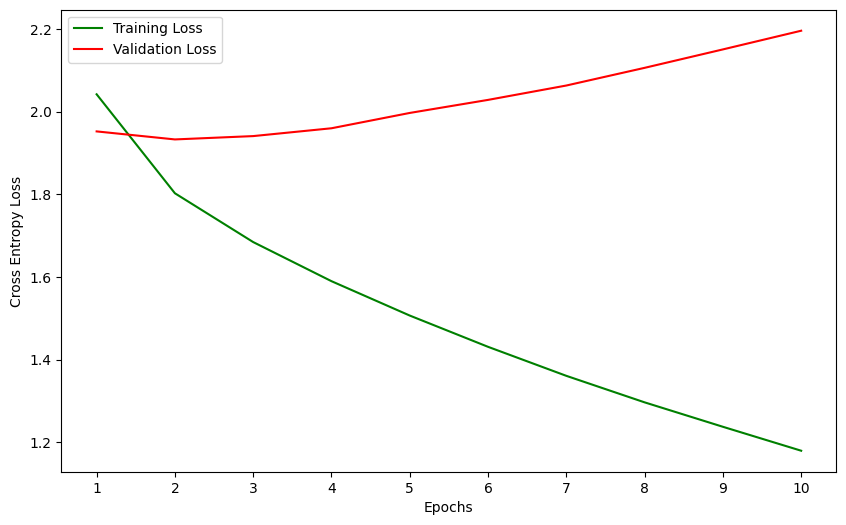

In [5]:
#loss plots:
plt.figure(figsize=(10,6))
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.xticks(np.arange(0, 21, 1))
eps = np.arange(1,11,1)
plt.plot(eps, train_loss,'g',label='Training Loss')
plt.plot(eps, val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


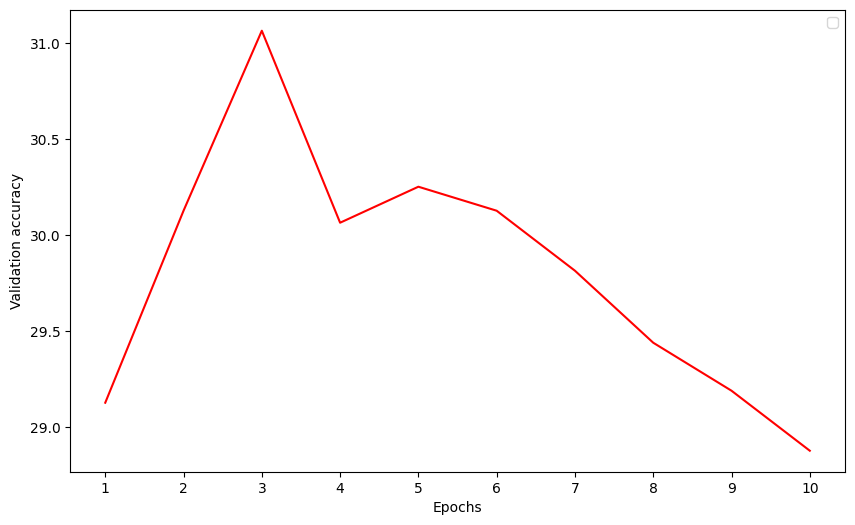

In [15]:
#accuracy plots:
plt.figure(figsize=(10,6))
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.xticks(np.arange(0, 11, 1))
eps = np.arange(1,11,1)
# plt.ylim(20,40)
plt.plot(eps, val_accs,'r')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


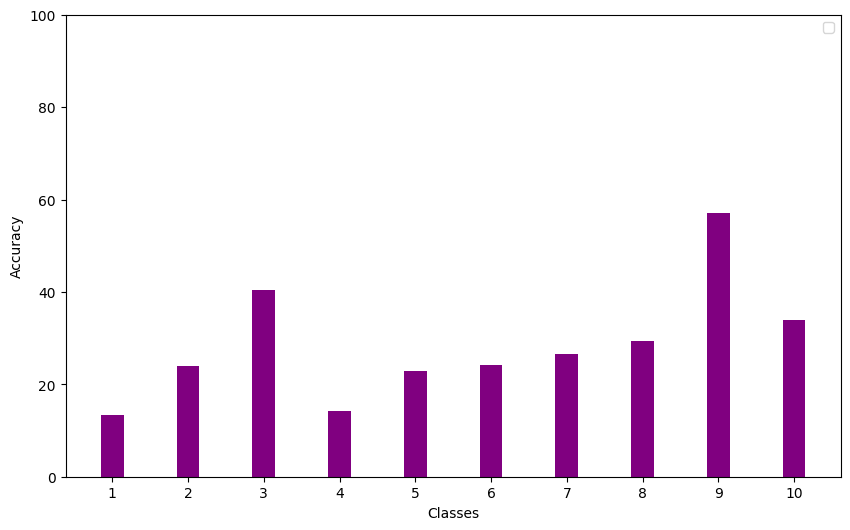

In [9]:
plt.figure(figsize=(10,6))
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 11, 1))
eps = np.arange(1,11,1)
plt.ylim(0,100)
plt.bar(eps, classaccs,color = 'purple', width=0.3)
plt.legend()
plt.show()